<a href="https://colab.research.google.com/github/vivian-xia/ComputerVision_MNIST/blob/main/Assignment_1_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Vivian Xia

##MSDS458 Research Assignment 1:

This assignment uses neural network model to classify MNIST digits. 

The DNN model will consist of 784 input nodes, a hidden layer with varying amount of nodes and 10 output nodes (corresponding to the 10 digits).

#Import packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from collections import Counter
from tabulate import tabulate
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


In [ ]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [ ]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Functions

In [ ]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')


def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")


def subplot_plot_digits(cl_a, cl_b):
  X_aa = test_images[(test_labels == cl_a) & (pred_classes == cl_a)]
  X_ab = test_images[(test_labels == cl_a) & (pred_classes == cl_b)]
  X_ba = test_images[(test_labels == cl_b) & (pred_classes == cl_a)]
  X_bb = test_images[(test_labels == cl_b) & (pred_classes == cl_b)]

  plt.figure(figsize=(8,8))

  p1 = plt.subplot(221)
  p2 = plt.subplot(222)
  p3 = plt.subplot(223)
  p4 = plt.subplot(224)

  plot_digits(X_aa[:25], p1, images_per_row=5);
  plot_digits(X_ab[:25], p2, images_per_row=5);
  plot_digits(X_ba[:25], p3, images_per_row=5);
  plot_digits(X_bb[:25], p4, images_per_row=5);


  p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
  p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
  p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
  p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

  # plt.savefig("error_analysis_digits_plot_EXP1_valid")

  plt.show()



#used in Random Forest Classifier
def plot_reduced_dim_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")


# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y


#Experiment 1: 
The dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### Exploratory data analysis

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


In [ ]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



In [ ]:
train_freq = Counter(train_labels).most_common()
print(tabulate(train_freq, headers=['Training Labels', 'Frequency'], tablefmt="fancy_grid"))

╒═══════════════════╤═════════════╕
│   Training Labels │   Frequency │
╞═══════════════════╪═════════════╡
│                 1 │        6742 │
├───────────────────┼─────────────┤
│                 7 │        6265 │
├───────────────────┼─────────────┤
│                 3 │        6131 │
├───────────────────┼─────────────┤
│                 2 │        5958 │
├───────────────────┼─────────────┤
│                 9 │        5949 │
├───────────────────┼─────────────┤
│                 0 │        5923 │
├───────────────────┼─────────────┤
│                 6 │        5918 │
├───────────────────┼─────────────┤
│                 8 │        5851 │
├───────────────────┼─────────────┤
│                 4 │        5842 │
├───────────────────┼─────────────┤
│                 5 │        5421 │
╘═══════════════════╧═════════════╛


In [ ]:
test_freq = Counter(test_labels).most_common()
print(tabulate(test_freq, headers=['Testing Labels', 'Frequency'], tablefmt="fancy_grid"))

╒══════════════════╤═════════════╕
│   Testing Labels │   Frequency │
╞══════════════════╪═════════════╡
│                1 │        1135 │
├──────────────────┼─────────────┤
│                2 │        1032 │
├──────────────────┼─────────────┤
│                7 │        1028 │
├──────────────────┼─────────────┤
│                3 │        1010 │
├──────────────────┼─────────────┤
│                9 │        1009 │
├──────────────────┼─────────────┤
│                4 │         982 │
├──────────────────┼─────────────┤
│                0 │         980 │
├──────────────────┼─────────────┤
│                8 │         974 │
├──────────────────┼─────────────┤
│                6 │         958 │
├──────────────────┼─────────────┤
│                5 │         892 │
╘══════════════════╧═════════════╛


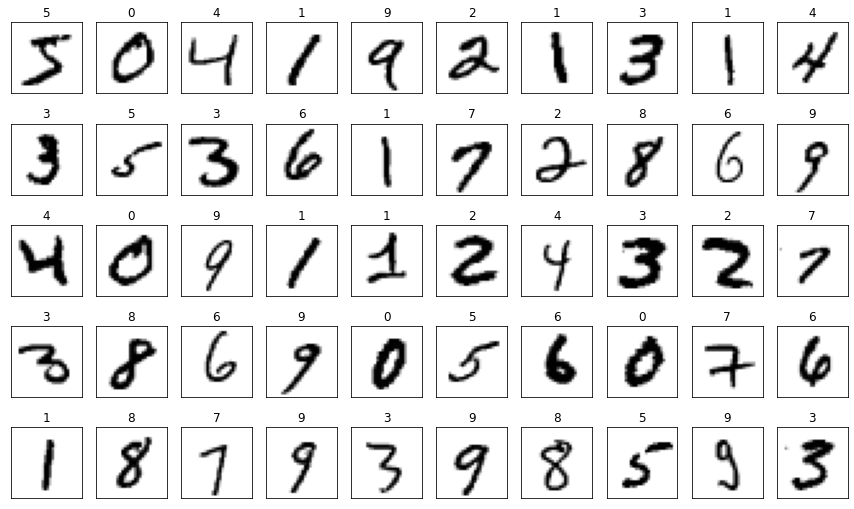

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(train_labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i].reshape(28,28), cmap='binary')

### Preprocess the data

In [ ]:
# Reshape and normalize the images
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

Set apart 5,000 samples of training data to use as a validation set. 

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 1 node with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(1, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


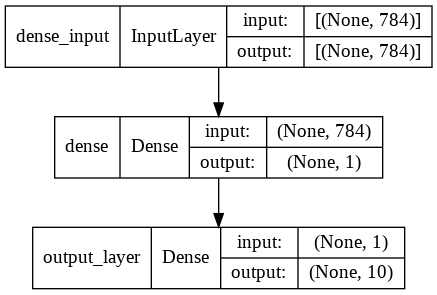

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 2s 40us/sample - loss: 1.9670 - accuracy: 0.2183 - val_loss: 1.8319 - val_accuracy: 0.2380
Epoch 2/50
   32/55000 [..............................] - ETA: 8s - loss: 1.8263 - accuracy: 0.2812

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 2s 38us/sample - loss: 1.7960 - accuracy: 0.2532 - val_loss: 1.7550 - val_accuracy: 0.2598
Epoch 3/50
55000/55000 [==============================] - 2s 37us/sample - loss: 1.7441 - accuracy: 0.2693 - val_loss: 1.7208 - val_accuracy: 0.2954
Epoch 4/50
55000/55000 [==============================] - 2s 36us/sample - loss: 1.7101 - accuracy: 0.2777 - val_loss: 1.6871 - val_accuracy: 0.2898
Epoch 5/50
55000/55000 [==============================] - 2s 36us/sample - loss: 1.6848 - accuracy: 0.2919 - val_loss: 1.6641 - val_accuracy: 0.3080
Epoch 6/50
55000/55000 [==============================] - 2s 36us/sample - loss: 1.6664 - accuracy: 0.3045 - val_loss: 1.6511 - val_accuracy: 0.3098
Epoch 7/50
55000/55000 [==============================] - 2s 36us/sample - loss: 1.6441 - accuracy: 0.3256 - val_loss: 1.6211 - val_accuracy: 0.3344
Epoch 8/50
55000/55000 [==============================] - 2s 36us/sample - loss: 1.6108 - accuracy: 0.3319 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.40389999747276306, test loss: 1.5584494379043579


The training set accuracy is 0.40, validation set accuracy is 0.41, test set accuracy is 0.40. The accuracy is all around the same value, so there does not seem to be overfitting. 

The model does not do well in predicting the test set. However, it does do better than if predicting by random. 

## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss and accuracy for each (training) epoch.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

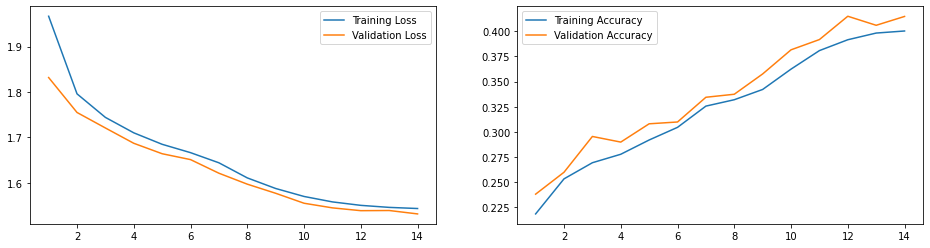

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

Loss is going in the right direction, but is nowhere near 0. The model is underfitted. Similarly, the accuracy is going up but is nowhere near 1. 

## Create and visualize confusion matrix

In [ ]:
pred_classes = np.argmax(model.predict(test_images), axis=-1)
pred_classes

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([7, 6, 1, ..., 9, 3, 6])

In [ ]:
conf_mx = confusion_matrix(test_labels, pred_classes)
conf_mx

array([[ 34,  56,  65,  13,   0,   0, 811,   0,   0,   1],
       [  4, 937,  25, 150,   3,   0,  16,   0,   0,   0],
       [ 27, 148, 103,  44,  15,   0, 692,   2,   0,   1],
       [  8, 312,  35, 475,  92,   0,  65,   6,   0,  17],
       [  0,  20,   5, 101, 672,   0,   9,  12,   0, 163],
       [  8, 247,  36, 405, 133,   0,  38,  12,   0,  13],
       [ 10,  27,  39,   4,   1,   0, 877,   0,   0,   0],
       [  0,  14,   3,  58, 213,   0,   5, 639,   0,  96],
       [  3, 233,  21, 549, 137,   0,  16,   4,   0,  11],
       [  0,  10,   2,  44, 331,   0,   5, 315,   0, 302]])

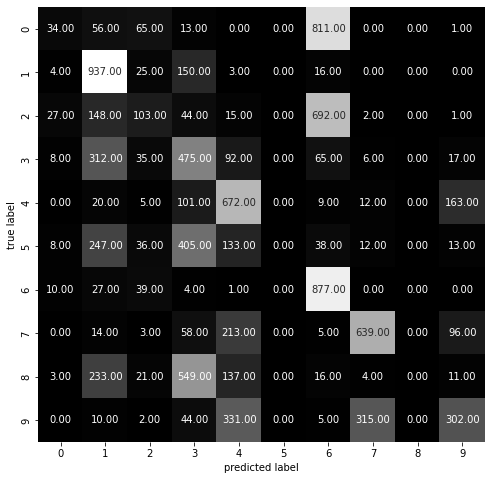

In [ ]:
plot_confusion_matrix(conf_mx)

The confusion matrix does not look good. Only diagonal cells should be "lit up". 

Normalize the confusion matrix to get the error rates.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)
norm_conf_mx

array([[0.03, 0.06, 0.07, 0.01, 0.  , 0.  , 0.83, 0.  , 0.  , 0.  ],
       [0.  , 0.83, 0.02, 0.13, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.03, 0.14, 0.1 , 0.04, 0.01, 0.  , 0.67, 0.  , 0.  , 0.  ],
       [0.01, 0.31, 0.03, 0.47, 0.09, 0.  , 0.06, 0.01, 0.  , 0.02],
       [0.  , 0.02, 0.01, 0.1 , 0.68, 0.  , 0.01, 0.01, 0.  , 0.17],
       [0.01, 0.28, 0.04, 0.45, 0.15, 0.  , 0.04, 0.01, 0.  , 0.01],
       [0.01, 0.03, 0.04, 0.  , 0.  , 0.  , 0.92, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.06, 0.21, 0.  , 0.  , 0.62, 0.  , 0.09],
       [0.  , 0.24, 0.02, 0.56, 0.14, 0.  , 0.02, 0.  , 0.  , 0.01],
       [0.  , 0.01, 0.  , 0.04, 0.33, 0.  , 0.  , 0.31, 0.  , 0.3 ]])

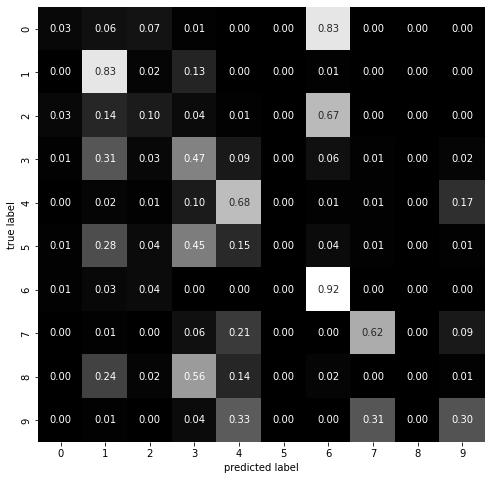

In [ ]:
plot_confusion_matrix(norm_conf_mx)

Looks like a lot of digits were misclassified as 6's. Let's plot examples of 6's and 0's to try to determine what went wrong here.

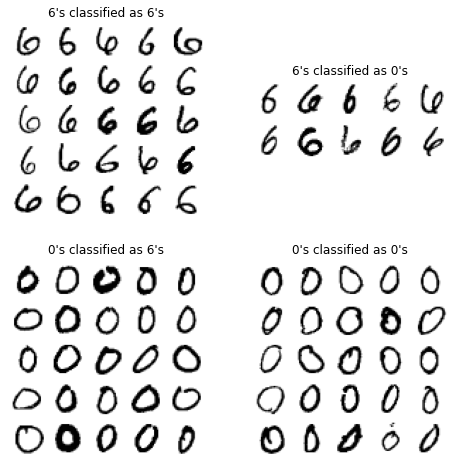

In [ ]:
subplot_plot_digits(6,0)

Those 0's classified as 6's (in the lower left hand corner) do not ook like 6's. The 0's classified 6's (in the upper right hand corner) also do not look like 0's.

## Getting the activation values of the hidden nodes
To get the activation values of the hidden nodes, we need to create a new model, activation_model, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the predict function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense/Relu:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'output_layer/Softmax:0' shape=(None, 10) dtype=float32>]

In [ ]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(55000, 1)

In [ ]:
print(f"The maximum activation value of the hidden node is {hidden_layer_activation.max()}")

The maximum activation value of the hidden node is 34.187530517578125


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.    0.    0.    0.    0.089 0.    0.    0.547 0.    0.364]
The sum of the probabilities is (approximately) 1.0


## Create the boxplot
We combine the activation values of the one hidden node with the corresponding predicted classes into a DataFrame. We use both matplotlib and seaborn to create boxplots from the DataFrame.

In [ ]:
pred_classes_train = np.argmax(model.predict(train_images), axis=-1)
pred_classes_train.shape

(55000,)

In [ ]:
boxplot_df = pd.DataFrame({'act_value':hidden_layer_activation.reshape(55000),
                           'pred_class':pred_classes_train})
boxplot_df.head()

,act_value,pred_class
0,10.600632,7
1,2.534049,3
2,6.658173,9
3,0.000000,6
4,0.863367,1


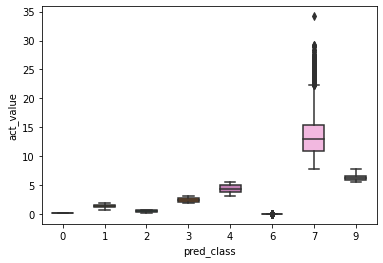

In [ ]:
# To see how closely the hidden nodes activation values correlate with the class predictions
bplot = sns.boxplot(y='act_value', x='pred_class', 
                 data=boxplot_df, 
                 width=0.5,
                 palette="colorblind")

We summarized 784 inputs into one feature/node. The y-axis is activated neurons. Despite some overlap, there is discrimination and a resulting decision boundary to these 10 classes from that one node. 

In [ ]:
# displaying the range of activation values for each class labels
boxplot_df.groupby("pred_class")["act_value"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,pred_class,act_value
0,0,"[0.09, 0.22]"
1,1,"[0.75, 1.85]"
2,2,"[0.22, 0.75]"
3,3,"[1.85, 3.18]"
4,4,"[3.18, 5.53]"
5,6,"[0.0, 0.09]"
6,7,"[7.76, 34.19]"
7,9,"[5.54, 7.75]"


#Experiment 2: 
The dense neural network will consist of 784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 2 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


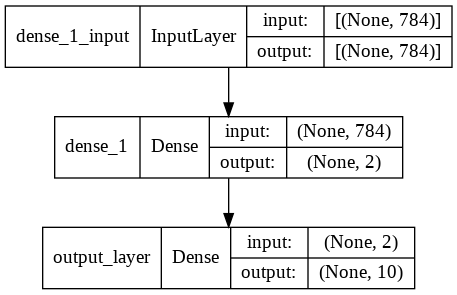

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 2s 44us/sample - loss: 1.5941 - accuracy: 0.4303 - val_loss: 1.3142 - val_accuracy: 0.5214
Epoch 2/50
   32/55000 [..............................] - ETA: 10s - loss: 1.2603 - accuracy: 0.5938

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 2s 43us/sample - loss: 1.2387 - accuracy: 0.5538 - val_loss: 1.1712 - val_accuracy: 0.5810
Epoch 3/50
55000/55000 [==============================] - 2s 42us/sample - loss: 1.1487 - accuracy: 0.5924 - val_loss: 1.1105 - val_accuracy: 0.6094
Epoch 4/50
55000/55000 [==============================] - 2s 41us/sample - loss: 1.1010 - accuracy: 0.6167 - val_loss: 1.0691 - val_accuracy: 0.6396
Epoch 5/50
55000/55000 [==============================] - 2s 42us/sample - loss: 1.0713 - accuracy: 0.6332 - val_loss: 1.0428 - val_accuracy: 0.6520
Epoch 6/50
55000/55000 [==============================] - 2s 40us/sample - loss: 1.0510 - accuracy: 0.6429 - val_loss: 1.0301 - val_accuracy: 0.6584
Epoch 7/50
55000/55000 [==============================] - 2s 42us/sample - loss: 1.0364 - accuracy: 0.6511 - val_loss: 1.0124 - val_accuracy: 0.6660
Epoch 8/50
55000/55000 [==============================] - 2s 42us/sample - loss: 1.0263 - accuracy: 0.6560 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.670799970626831, test loss: 1.0028791440963745


The training set accuracy is 0.66, validation set accuracy is 0.67, test set accuracy is 0.67. The accuracy is all around the same value, so there does not seem to be overfitting. 

The model does not do well in predicting the test set. However, it does do better than if predicting by random. 

## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

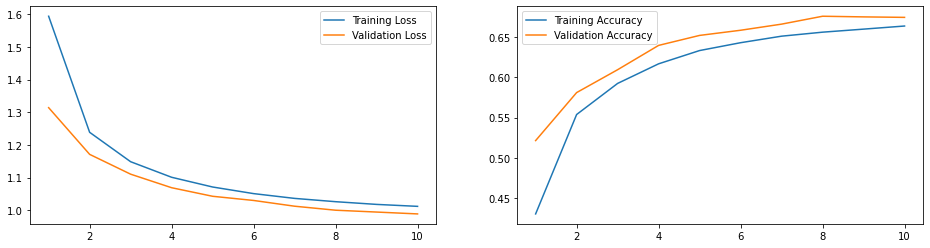

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Create and visualize confusion matrix

In [ ]:
pred_classes = np.argmax(model.predict(test_images), axis=-1)
pred_classes

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([7, 6, 1, ..., 9, 5, 6])

In [ ]:
conf_mx = confusion_matrix(test_labels, pred_classes)
conf_mx

array([[ 773,    0,    5,   54,    0,   55,   67,    1,   25,    0],
       [   0, 1081,   27,   11,    0,    0,    2,   10,    4,    0],
       [  14,   75,  728,   84,    4,    1,   96,   13,   14,    3],
       [  40,   31,  196,  498,    7,   56,   24,   29,  124,    5],
       [   4,    0,    6,   13,  511,   24,    3,   23,   80,  318],
       [  75,    4,   26,   87,   31,  486,   13,    7,  155,    8],
       [  73,    2,   99,   23,    2,   13,  743,    1,    2,    0],
       [   1,   60,    8,   14,   11,    1,    0,  809,   13,  111],
       [  45,   12,   16,  170,   41,  259,    3,   15,  403,   10],
       [   5,    3,    1,    5,  151,   14,    0,  126,   28,  676]])

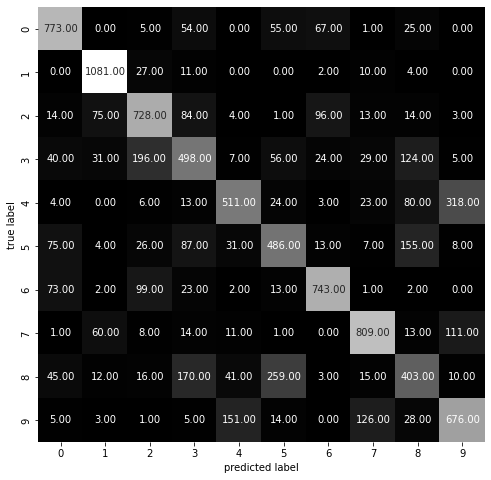

In [ ]:
plot_confusion_matrix(conf_mx)

The confusion matrix does look better than Experiment 1's. The diagonal cells are "lit up". 

Normalize the confusion matrix to get the error rates.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)
norm_conf_mx

array([[0.79, 0.  , 0.01, 0.06, 0.  , 0.06, 0.07, 0.  , 0.03, 0.  ],
       [0.  , 0.95, 0.02, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.01, 0.07, 0.71, 0.08, 0.  , 0.  , 0.09, 0.01, 0.01, 0.  ],
       [0.04, 0.03, 0.19, 0.49, 0.01, 0.06, 0.02, 0.03, 0.12, 0.  ],
       [0.  , 0.  , 0.01, 0.01, 0.52, 0.02, 0.  , 0.02, 0.08, 0.32],
       [0.08, 0.  , 0.03, 0.1 , 0.03, 0.54, 0.01, 0.01, 0.17, 0.01],
       [0.08, 0.  , 0.1 , 0.02, 0.  , 0.01, 0.78, 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.01, 0.01, 0.01, 0.  , 0.  , 0.79, 0.01, 0.11],
       [0.05, 0.01, 0.02, 0.17, 0.04, 0.27, 0.  , 0.02, 0.41, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.15, 0.01, 0.  , 0.12, 0.03, 0.67]])

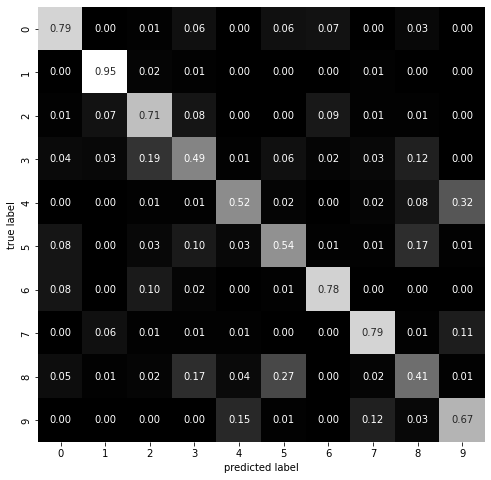

In [ ]:
plot_confusion_matrix(norm_conf_mx)

Looks like a few digits were misclassified. Let's plot examples of 9's and 4's as well as 5's and 8's to try to determine what went wrong here.

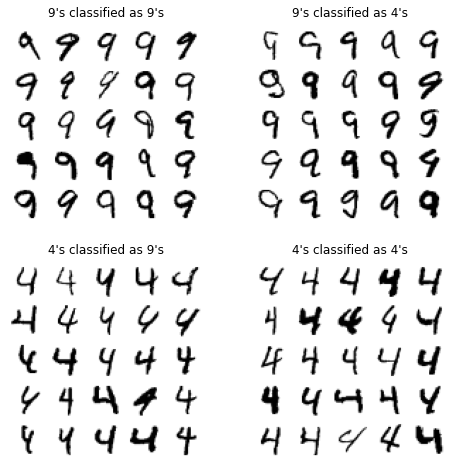

In [ ]:
subplot_plot_digits(9,4)

Those 4's classified as 9's (in the lower left hand corner) do NOT look like 9's! Also those 9's classified 4's (in the upper right hand corner) do not look like 4's. 

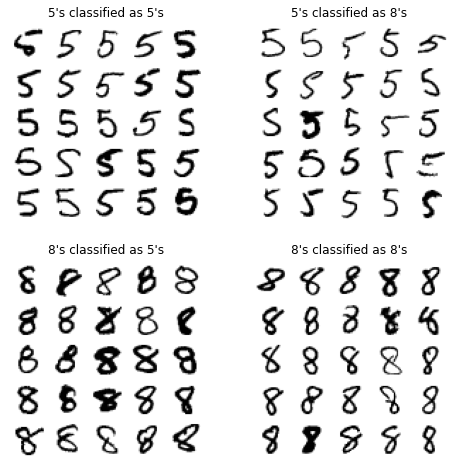

In [ ]:
subplot_plot_digits(5, 8)

Those 8's classified as 5's (in the lower left hand corner) do NOT look like 5's! Also most of those 5's classified 8's (in the upper right hand corner) do not look like 8's, some do. 

## Getting the activation values of the hidden nodes
To get the activation values of the hidden nodes, we need to create a new model, activation_model, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the predict function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense_1/Relu:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'output_layer_1/Softmax:0' shape=(None, 10) dtype=float32>]

In [ ]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(55000, 2)

In [ ]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 33.212467193603516
The maximum activation value of the second hidden node is 24.09656524658203


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.    0.069 0.002 0.008 0.016 0.001 0.    0.819 0.009 0.077]
The sum of the probabilities is (approximately) 1.0000001192092896


## Create the scatterplots
Combine the activation values of the two hidden nodes together with the corresponding predicted classes into a DataFrame. `Matplotlib` is used to create scatterplots from the DataFrame.

In [ ]:
pred_classes_train = np.argmax(model.predict(train_images), axis=-1)
pred_classes_train.shape

(55000,)

In [ ]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class': pred_classes_train})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,0.000000,2.453797,7
1,5.497410,3.346977,3
2,4.668513,9.536420,9
3,9.470518,0.000000,6
4,0.000000,0.000000,1


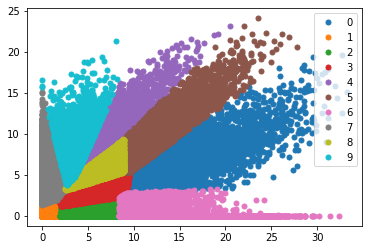

In [ ]:
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=5, label=name)
ax.legend()

plt.show()


The scatter plot of the two features show that the inputs are discriminated against, creating 10 distinct clusters. The clusters are still overlapping, but the two features are able to discriminate the 10 classes. 

#Experiment 3:
DNN with 1 hidden layer and 100 nodes.

### Load MNIST data

In [ ]:
(train_images_original, train_labels_original), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images_original.copy()
train_labels = train_labels_original.copy()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 100 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


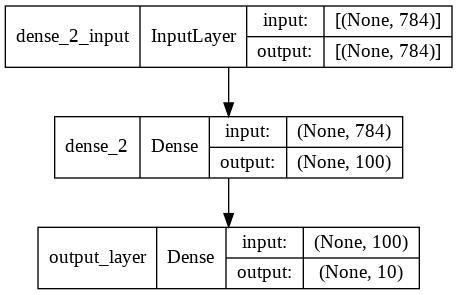

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2746 - accuracy: 0.9223 - val_loss: 0.1466 - val_accuracy: 0.9592
Epoch 2/50
   32/55000 [..............................] - ETA: 13s - loss: 0.2264 - accuracy: 0.9062

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 5s 84us/sample - loss: 0.1320 - accuracy: 0.9617 - val_loss: 0.1114 - val_accuracy: 0.9678
Epoch 3/50
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0983 - accuracy: 0.9715 - val_loss: 0.0961 - val_accuracy: 0.9716
Epoch 4/50
55000/55000 [==============================] - 5s 82us/sample - loss: 0.0796 - accuracy: 0.9761 - val_loss: 0.0993 - val_accuracy: 0.9714
Epoch 5/50
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0676 - accuracy: 0.9804 - val_loss: 0.0884 - val_accuracy: 0.9762
Epoch 6/50
55000/55000 [==============================] - 4s 81us/sample - loss: 0.0591 - accuracy: 0.9826 - val_loss: 0.0924 - val_accuracy: 0.9748
Epoch 7/50
55000/55000 [==============================] - 4s 80us/sample - loss: 0.0519 - accuracy: 0.9851 - val_loss: 0.0874 - val_accuracy: 0.9764
Epoch 8/50
55000/55000 [==============================] - 4s 79us/sample - loss: 0.0460 - accuracy: 0.9872 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9728000164031982, test loss: 0.107152517780778


## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

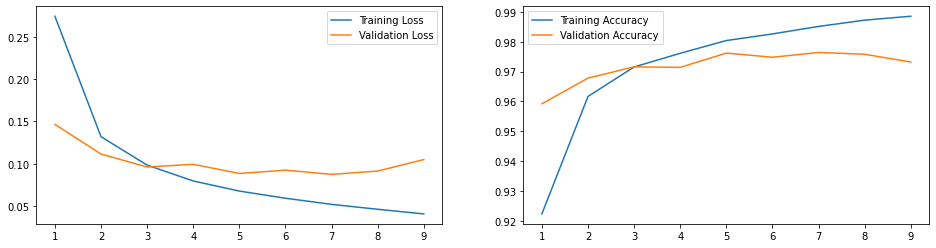

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training accuracy continues to improve while the validation accuracy flattens out. The model is potentially overfitting. However the difference between the accuracy for training and validation is 0.02, so the difference is not that big so the model may not be overfitting just yet. 

## Create and visualize confusion matrix

In [ ]:
pred_classes = np.argmax(model.predict(test_images), axis=-1)
pred_classes

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
conf_mx = confusion_matrix(test_labels, pred_classes)
conf_mx

array([[ 968,    0,    0,    3,    0,    1,    3,    3,    1,    1],
       [   0, 1121,    3,    4,    0,    0,    1,    2,    4,    0],
       [   4,    1,  998,   11,    3,    0,    2,    9,    4,    0],
       [   0,    0,    2,  994,    0,    0,    0,    9,    2,    3],
       [   2,    0,    4,    1,  954,    0,    3,    3,    1,   14],
       [   2,    0,    1,   25,    0,  847,    5,    5,    3,    4],
       [   5,    3,    1,    0,    3,    8,  935,    1,    2,    0],
       [   0,    3,    7,    4,    0,    0,    0, 1009,    1,    4],
       [   3,    1,    7,   16,    6,    5,    4,    4,  919,    9],
       [   0,    3,    0,    9,    6,    1,    1,    6,    0,  983]])

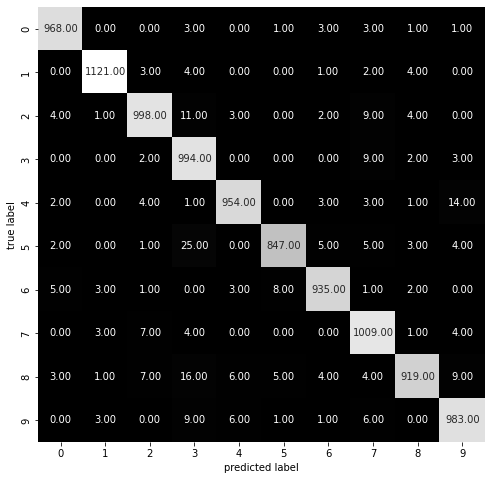

In [ ]:
plot_confusion_matrix(conf_mx)

The confusion matrix does look better than Experiment 1 and 2's. The diagonal cells are "lit up."

Let us normalize the confusion matrix to get the error rates.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)
norm_conf_mx

array([[0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.95, 0.01, 0.01, 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.02, 0.01, 0.01, 0.  , 0.  , 0.94, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.97]])

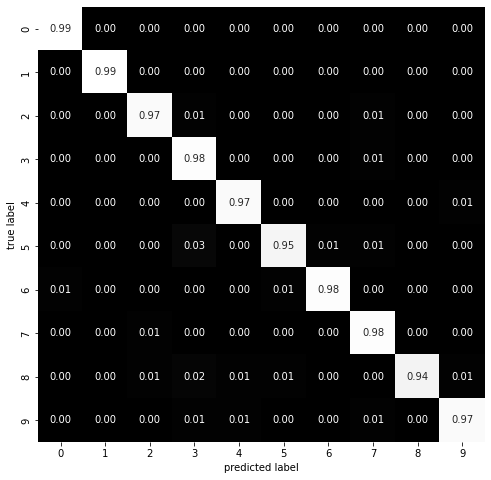

In [ ]:
plot_confusion_matrix(norm_conf_mx)

Looks like most digits were classified correctly. There are a few mislabeled but the error rates are only 0.01.

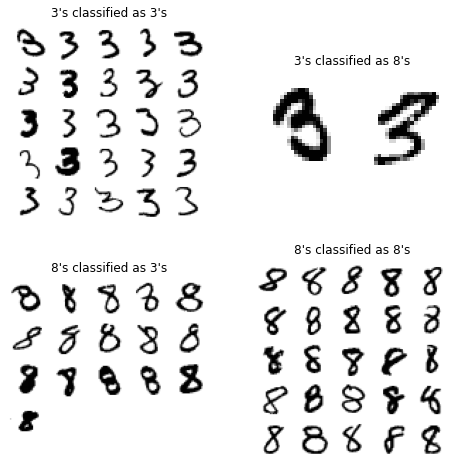

In [ ]:
subplot_plot_digits(3, 8)

The number of misclassified is less than that of Experiment 1 and 2's. 

## Getting the activation values of the hidden nodes
To get the activation values of the hidden nodes, we need to create a new model, activation_model, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the predict function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense_2/Relu:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'output_layer_2/Softmax:0' shape=(None, 10) dtype=float32>]

In [ ]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
output_layer_activation = activations[1]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(55000, 100)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 18.776756286621094


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
print(f"The output node has shape {output_layer_activation.shape}")
print(f"The output for the first image are {output_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {output_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.    0.    0.    0.001 0.    0.    0.    0.999 0.    0.   ]
The sum of the probabilities is (approximately) 1.0


## Use t-Distributed Stochastic Neighbor Embedding (t-SNE) to reduce the (activation) features from 100 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets.

Use T-score stochastic neighboring embedding on the nodes. We have 100 nodes and get the distance between two, plot on a 1-D line, maintain the distance. From that 1-D line, plots it on a T-distribution curve.

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':train_labels}
for k in range(0,100): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head()

,actual_class,act_val_0,act_val_1,act_val_2,act_val_3,act_val_4,act_val_5,act_val_6,act_val_7,act_val_8,act_val_9,act_val_10,act_val_11,act_val_12,act_val_13,act_val_14,act_val_15,act_val_16,act_val_17,act_val_18,act_val_19,act_val_20,act_val_21,act_val_22,act_val_23,act_val_24,act_val_25,act_val_26,act_val_27,act_val_28,act_val_29,act_val_30,act_val_31,act_val_32,act_val_33,act_val_34,act_val_35,act_val_36,act_val_37,act_val_38,...,act_val_60,act_val_61,act_val_62,act_val_63,act_val_64,act_val_65,act_val_66,act_val_67,act_val_68,act_val_69,act_val_70,act_val_71,act_val_72,act_val_73,act_val_74,act_val_75,act_val_76,act_val_77,act_val_78,act_val_79,act_val_80,act_val_81,act_val_82,act_val_83,act_val_84,act_val_85,act_val_86,act_val_87,act_val_88,act_val_89,act_val_90,act_val_91,act_val_92,act_val_93,act_val_94,act_val_95,act_val_96,act_val_97,act_val_98,act_val_99
0,7,3.729756,0.0,0.000000,0.780826,0.000000,0.000000,4.434834,0.000000,0.000000,0.000000,0.000000,0.161890,0.000000,4.498572,7.413114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.988677,6.406325,0.806464,0.000000,0.000000,0.258333,0.00000,0.000000,0.000000,7.231872,3.806761,3.045857,0.000000,0.000000,5.061924,0.000000,4.807237,3.577451,...,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,3.006418,0.155937,3.790461,0.000000,5.317240,1.214078,0.121442,6.127510,0.000000,0.000000,0.000000,1.485497,0.000000,2.011789,2.909816,0.503066,0.000000,2.332966,0.950359,0.000000,0.000000,0.000000,0.000000,0.807394,4.950253,0.034273,0.0,3.767731,0.000000,0.000000,0.000000,0.000000
1,3,0.000000,0.0,3.294915,0.000000,0.017898,2.116379,0.000000,1.413037,3.495900,7.615080,0.000000,0.288265,1.968156,6.299760,3.478083,0.000000,1.118027,0.000000,0.000000,1.609931,1.539310,2.250537,3.141612,0.610038,0.000000,4.487475,1.905009,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.747808,0.053483,2.130831,0.000000,0.000000,...,1.685679,0.0,0.0507,2.712829,2.105357,0.000000,0.000000,0.480114,3.168056,1.870221,1.264580,0.408988,0.000000,0.000000,0.000000,0.000000,5.705482,0.206392,0.918311,0.000000,1.430957,5.832239,0.000000,0.000000,4.093786,0.000000,0.000000,0.000000,6.848024,0.000000,3.920762,2.660318,0.000000,1.429722,0.0,0.000000,9.329060,0.000000,0.776810,0.000000
2,4,0.000000,0.0,0.254999,0.000000,0.000000,4.218351,0.652626,0.000000,2.189546,1.540154,0.000000,0.926311,0.000000,5.038351,0.000000,1.233435,0.000000,0.000000,0.000000,0.000000,3.204882,0.000000,3.201689,0.000000,1.910397,0.000000,1.008733,1.77845,0.000000,0.000000,2.358416,0.000000,0.000000,0.227188,0.235018,0.000000,0.531881,3.004984,0.000000,...,0.000000,0.0,0.0000,0.000000,0.431427,1.187113,0.000000,0.000000,2.403833,2.307350,0.184609,1.718201,3.722806,1.676314,0.239642,1.571752,1.242527,0.000000,0.000000,5.421781,2.066226,7.833174,3.083724,0.000000,0.883244,0.004944,0.000000,1.179608,3.411224,0.000000,0.000000,1.786994,1.582525,1.925085,0.0,0.000000,1.366046,2.746671,0.000000,1.339116
3,6,0.340070,0.0,0.370699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.398133,2.458392,0.000000,0.000000,0.000000,0.265930,0.000000,1.116286,2.427052,0.000000,0.000000,0.000000,5.340864,0.000000,0.000000,0.058341,0.000000,0.00000,0.963189,3.883580,0.000000,0.000000,0.861071,1.834765,0.000000,0.000000,0.000000,0.000000,1.291839,...,0.000000,0.0,0.0000,0.000000,0.000000,1.493157,0.386661,2.009096,0.110965,0.000000,1.226579,0.552767,0.627175,0.000000,0.000000,2.704370,0.943788,0.000000,0.000000,0.000000,0.000000,0.000000,4.922123,0.709919,1.364021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.430975,0.000000,0.227903,0.0,0.000000,3.119340,0.000000,1.553989,0.000000
4,1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.045432,1.998348,0.000000,1.846534,0.000000,0.000000,0.668966,0.000000,1.315467,0.000000,0.000000,3.534941,0.000000,1.766345,0.000000,0.000000,3.779757,0.209140,1.237581,2.632975,0.000000,0.00000,0.296522,1.909084,0.000000,0.000000,1.012812,0.000000,1.092024,0.0000

In [ ]:
N=55000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(55000, 101)

In [ ]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activation_df_subset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 55000 samples in 0.007s...
[t-SNE] Computed neighbors for 55000 samples in 84.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55000
[t-SNE] Computed conditional probabilities for sample 2000 / 55000
[t-SNE] Computed conditional probabilities for sample 3000 / 55000
[t-SNE] Computed conditional probabilities for sample 4000 / 55000
[t-SNE] Computed conditional probabilities for sample 5000 / 55000
[t-SNE] Computed conditional probabilities for sample 6000 / 55000
[t-SNE] Computed conditional probabilities for sample 7000 / 55000
[t-SNE] Computed conditional probabilities for sample 8000 / 55000
[t-SNE] Computed conditional probabilities for sample 9000 / 55000
[t-SNE] Computed conditional probabilities for sample 10000 / 55000
[t-SNE] Computed conditional probabilities for sample 11000 / 55000
[t-SNE] Computed conditional probabilities for sample 12000 / 55000
[t-SNE] Computed conditional probabilities for s

In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

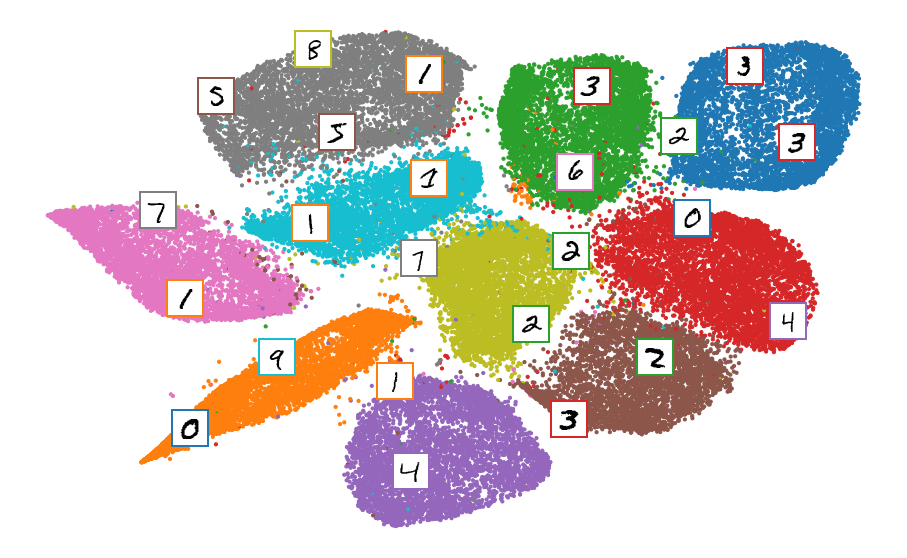

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=train_labels, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images_original[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(train_labels_original[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

The 100 features do discriminate the 10 classes. Some are misclassified which can be seen from the some colored dots in different colored clusters. Good clustering from the model overall.



#Experiment 4:
DNN with 1 hidden layer and 50 nodes.

### Load MNIST data

In [ ]:
(train_images_original, train_labels_original), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images_original.copy()
train_labels = train_labels_original.copy()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 50 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                39250     
                                                                 
 output_layer (Dense)        (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


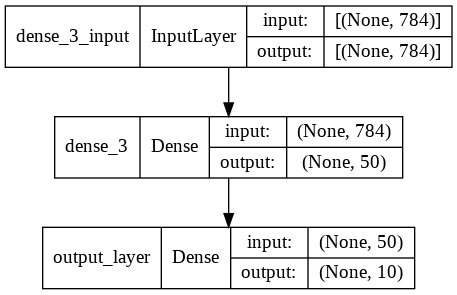

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3286 - accuracy: 0.9077 - val_loss: 0.1884 - val_accuracy: 0.9486
Epoch 2/50
   32/55000 [..............................] - ETA: 11s - loss: 0.1952 - accuracy: 0.9375

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 3s 61us/sample - loss: 0.1699 - accuracy: 0.9506 - val_loss: 0.1384 - val_accuracy: 0.9626
Epoch 3/50
55000/55000 [==============================] - 3s 59us/sample - loss: 0.1327 - accuracy: 0.9621 - val_loss: 0.1188 - val_accuracy: 0.9690
Epoch 4/50
55000/55000 [==============================] - 3s 59us/sample - loss: 0.1122 - accuracy: 0.9675 - val_loss: 0.1156 - val_accuracy: 0.9688
Epoch 5/50
55000/55000 [==============================] - 3s 59us/sample - loss: 0.0994 - accuracy: 0.9719 - val_loss: 0.1101 - val_accuracy: 0.9702
Epoch 6/50
55000/55000 [==============================] - 3s 58us/sample - loss: 0.0894 - accuracy: 0.9749 - val_loss: 0.1089 - val_accuracy: 0.9704
Epoch 7/50
55000/55000 [==============================] - 3s 60us/sample - loss: 0.0825 - accuracy: 0.9767 - val_loss: 0.1095 - val_accuracy: 0.9712
Epoch 8/50
55000/55000 [==============================] - 3s 57us/sample - loss: 0.0774 - accuracy: 0.9789 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9710999727249146, test loss: 0.11436305485037156


The training, validation, and test set accuracy are around 0.97, a high accuracy score. 

## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

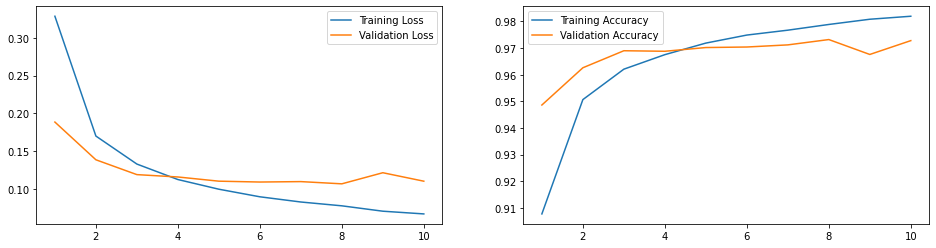

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training accuracy continues to improve while the validation accuracy flattens out. The model is potentially overfitting. However the difference between the accuracy for training and validation is 0.01, so the difference is not that big so the model may not be overfitting just yet. 

## Create and visualize confusion matrix

In [ ]:
pred_classes = np.argmax(model.predict(test_images), axis=-1)
pred_classes

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
conf_mx = confusion_matrix(test_labels, pred_classes)
conf_mx

array([[ 965,    0,    1,    1,    4,    2,    2,    2,    2,    1],
       [   0, 1118,    4,    2,    0,    0,    4,    1,    6,    0],
       [   4,    1,  996,    2,    4,    0,    3,    5,   17,    0],
       [   0,    0,    7,  980,    1,    3,    0,    8,    8,    3],
       [   2,    0,    4,    1,  956,    0,    0,    8,    0,   11],
       [   2,    0,    0,    9,    2,  861,    8,    2,    5,    3],
       [   4,    3,    1,    1,   13,    4,  927,    1,    4,    0],
       [   1,    4,   11,    4,    0,    0,    0, 1000,    2,    6],
       [   3,    2,    6,    6,    6,    4,    1,    7,  934,    5],
       [   2,    3,    0,    4,   10,    1,    1,    9,    5,  974]])

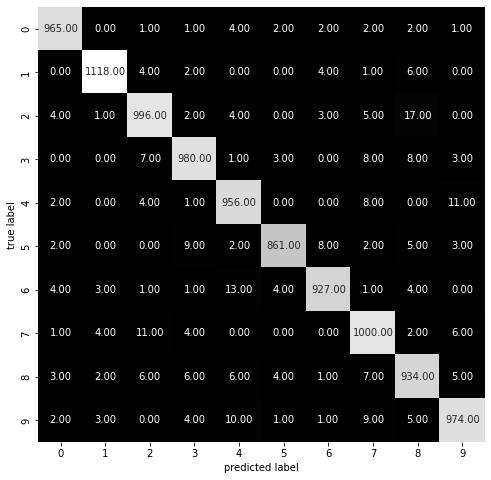

In [ ]:
plot_confusion_matrix(conf_mx)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)
norm_conf_mx

array([[0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.01, 0.97, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.01, 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.97, 0.01, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.97, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.01],
       [0.  , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.01, 0.96, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.97]])

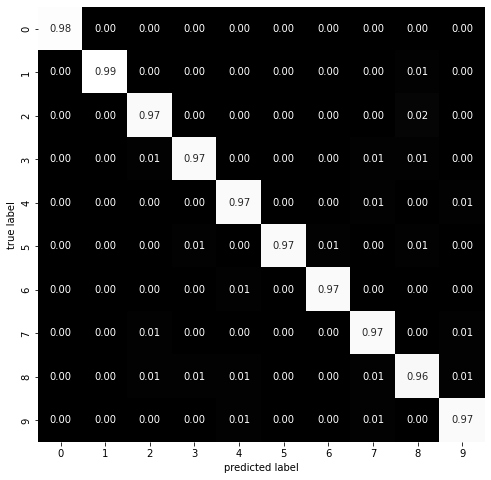

In [ ]:
plot_confusion_matrix(norm_conf_mx)

Looks like most digits were classified correctly. There are a few mislabeled but the error rates are only 0.01.

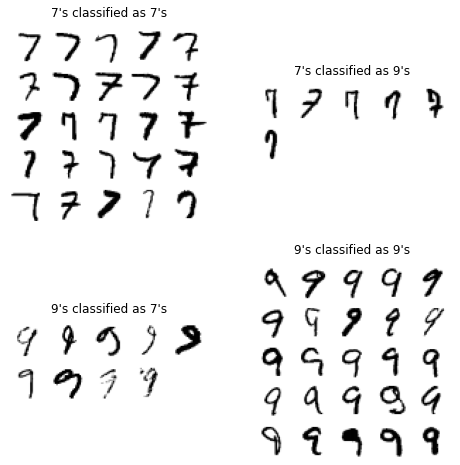

In [ ]:
subplot_plot_digits(7,9)

## Getting the activation values of the hidden nodes
To get the activation values of the hidden nodes, we need to create a new model, activation_model, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the predict function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense_3/Relu:0' shape=(None, 50) dtype=float32>,
 <tf.Tensor 'output_layer_3/Softmax:0' shape=(None, 10) dtype=float32>]

In [ ]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
output_layer_activation = activations[1]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(55000, 50)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 27.515933990478516


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
print(f"The output node has shape {output_layer_activation.shape}")
print(f"The output for the first image are {output_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {output_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The sum of the probabilities is (approximately) 0.9999998807907104


## Use t-Distributed Stochastic Neighbor Embedding (t-SNE) to reduce the (activation) features from 50 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.


Use T-score stochasic neighboring embedding on the nodes. We have 50 nodes and get the distance between two, plot on a 1-D line, maintain the distance. From that 1-D line, plots it on a T-distribution curve.

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':train_labels}
for k in range(0,50): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head()

,actual_class,act_val_0,act_val_1,act_val_2,act_val_3,act_val_4,act_val_5,act_val_6,act_val_7,act_val_8,act_val_9,act_val_10,act_val_11,act_val_12,act_val_13,act_val_14,act_val_15,act_val_16,act_val_17,act_val_18,act_val_19,act_val_20,act_val_21,act_val_22,act_val_23,act_val_24,act_val_25,act_val_26,act_val_27,act_val_28,act_val_29,act_val_30,act_val_31,act_val_32,act_val_33,act_val_34,act_val_35,act_val_36,act_val_37,act_val_38,act_val_39,act_val_40,act_val_41,act_val_42,act_val_43,act_val_44,act_val_45,act_val_46,act_val_47,act_val_48,act_val_49
0,7,2.943936,2.198009,0.000000,0.000000,0.506071,0.000000,0.000000,5.377055,0.588180,0.221831,0.835598,0.041900,1.788591,0.000000,6.835907,7.402278,0.000000,2.666951,0.000000,0.000000,8.007925,0.000000,5.079115,1.792541,0.000000,1.354469,0.000000,4.286104,0.000000,0.000000,2.285522,0.000000,8.026868,4.024973,0.000000,0.000000,4.882582,2.954933,0.000000,5.789179,0.000000,0.051879,0.000000,0.000000,0.000000,0.362659,0.000000,0.000000,2.384296,1.409568
1,3,0.113037,0.000000,1.387539,1.652398,0.317104,0.000000,0.000000,2.001518,1.045031,2.331887,8.250563,7.330504,0.000000,3.487124,0.000000,9.096399,4.179662,1.790405,0.000000,0.835599,5.848468,6.061459,2.689195,0.000000,0.723469,0.000000,0.000000,2.087715,1.906207,0.000000,0.155176,5.237438,1.802128,0.000000,0.000000,0.000000,5.625766,3.171577,6.611795,0.000000,2.508455,2.452723,0.000000,0.922147,5.324874,0.000000,3.264247,3.873328,0.734147,0.735495
2,4,0.000000,2.834370,0.000000,3.108688,0.000000,4.478684,0.000000,0.000000,0.194586,0.000000,0.073011,2.709139,1.730802,2.432581,1.046328,5.506071,0.000000,2.616285,0.000000,0.000000,5.623519,2.104307,3.284399,0.000000,0.000000,0.427377,0.000000,3.595426,0.000000,1.441477,2.462194,2.432159,0.499162,0.437430,0.632846,3.804891,5.227851,0.000000,3.433266,0.722794,1.147996,1.302763,0.000000,0.000000,2.882936,0.000000,0.000000,1.041924,0.626485,4.647212
3,6,0.000000,1.666114,1.196283,0.000000,0.000000,0.000000,2.895983,0.000000,0.279400,0.000000,0.000000,0.000000,0.558243,0.000000,0.000000,2.016199,0.000000,3.505777,0.000000,0.000000,6.090939,0.000000,0.000000,5.027699,0.000000,1.837315,2.202742,0.000000,0.000000,0.000000,2.903054,0.000000,1.963872,2.152296,0.000000,3.311925,0.000000,1.881027,0.559391,0.000000,0.000000,4.108458,2.435279,3.153127,0.000000,2.002029,2.184105,1.452424,0.000000,3.569183
4,1,0.000000,0.877335,2.683655,1.961667,0.382840,0.000000,3.162169,2.211847,0.000000,0.000000,2.237515,0.888124,0.000000,0.000000,0.000000,4.899395,0.000000,0.000000,2.589453,0.000000,4.487820,1.523818,0.777371,0.000000,0.000000,0.000000,0.515224,0.000000,0.000000,0.000000,0.976996,2.144496,0.000000,0.000000,0.000000,0.000000,0.000000,3.896984,0.000000,0.000000,0.690530,0.152508,2.201275,3.482857,1.721088,2.748133,0.435787,0.752740,0.600195,0.542974


In [ ]:
N=55000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(55000, 51)

In [ ]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activation_df_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 55000 samples in 0.004s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 55000 samples in 76.932s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55000
[t-SNE] Computed conditional probabilities for sample 2000 / 55000
[t-SNE] Computed conditional probabilities for sample 3000 / 55000
[t-SNE] Computed conditional probabilities for sample 4000 / 55000
[t-SNE] Computed conditional probabilities for sample 5000 / 55000
[t-SNE] Computed conditional probabilities for sample 6000 / 55000
[t-SNE] Computed conditional probabilities for sample 7000 / 55000
[t-SNE] Computed conditional probabilities for sample 8000 / 55000
[t-SNE] Computed conditional probabilities for sample 9000 / 55000
[t-SNE] Computed conditional probabilities for sample 10000 / 55000
[t-SNE] Computed conditional probabilities for sample 11000 / 55000
[t-SNE] Computed conditional probabilities for sample 12000 / 55000
[t-SNE] Computed conditional probabilities for sample 13000 / 55000
[t-SNE] Computed conditional probabilities for sample 14000 / 5500

In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

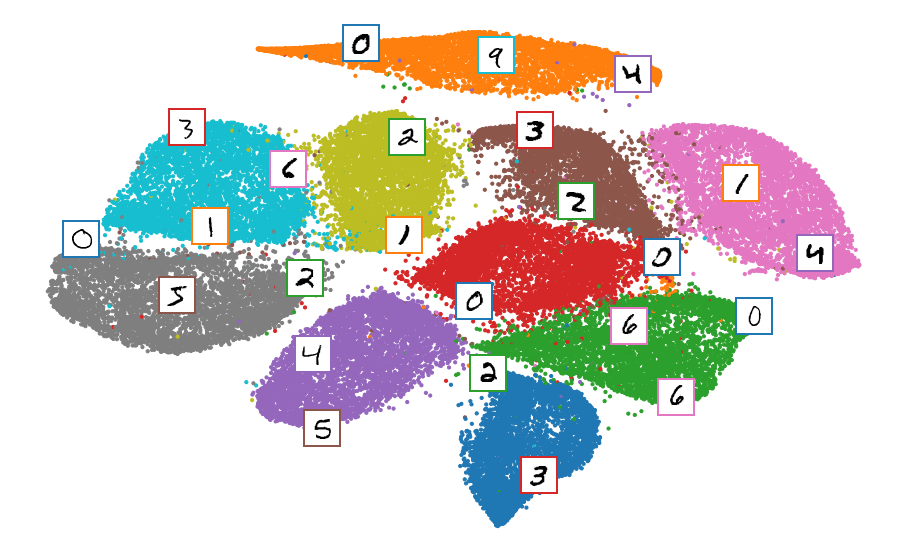

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=train_labels, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images_original[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(train_labels_original[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

The 88 features do discriminate the 10 classes. Some are misclassified which can be seen from the some colored dots in different colored clusters. Good clustering from the model overall.



#Experiment 5: 
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). 


### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using sparse_categorical_crossentropy as the loss function we do not need to use to_categorical to convert the class vector of labels to binary matrix representation.

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with PCA decomposition.

In [ ]:
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [ ]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

## Build, train, and test the network (without reducing dimensions)
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 55)                43175     
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 43,735
Trainable params: 43,735
Non-trainable params: 0
_________________________________________________________________


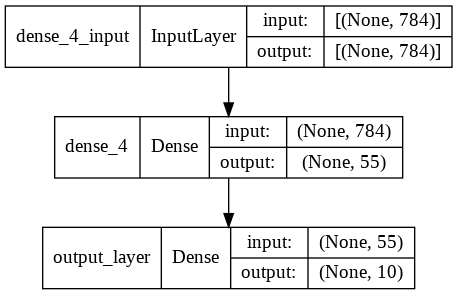

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3153 - accuracy: 0.9103 - val_loss: 0.1887 - val_accuracy: 0.9440


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.1692 - accuracy: 0.9507 - val_loss: 0.1517 - val_accuracy: 0.9560
Epoch 3/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.1313 - accuracy: 0.9624 - val_loss: 0.1228 - val_accuracy: 0.9660
Epoch 4/50
55000/55000 [==============================] - 3s 59us/sample - loss: 0.1094 - accuracy: 0.9682 - val_loss: 0.1175 - val_accuracy: 0.9668
Epoch 5/50
55000/55000 [==============================] - 3s 59us/sample - loss: 0.0956 - accuracy: 0.9734 - val_loss: 0.1212 - val_accuracy: 0.9642
Epoch 6/50
55000/55000 [==============================] - 3s 60us/sample - loss: 0.0845 - accuracy: 0.9764 - val_loss: 0.1167 - val_accuracy: 0.9672
Epoch 7/50
55000/55000 [==============================] - 3s 60us/sample - loss: 0.0772 - accuracy: 0.9781 - val_loss: 0.1054 - val_accuracy: 0.9718
Epoch 8/50
55000/55000 [==============================] - 3s 60us/sample - loss: 0.0708 - accuracy: 0.9805

### Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9703999757766724, test loss: 0.1155710300180479


### Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

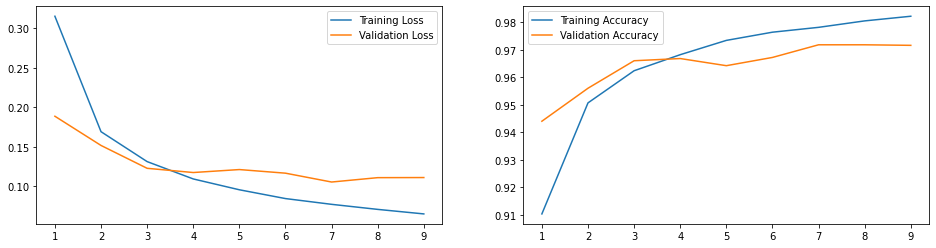

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Build, train, and test the network with reduced dimensions
The network will have 2 Dense layers. The first hidden layer will consist of 65 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(154,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 55)                8525      
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 9,085
Trainable params: 9,085
Non-trainable params: 0
_________________________________________________________________


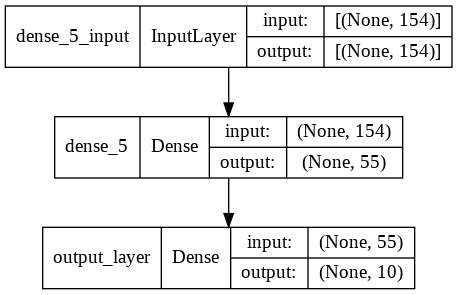

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_red, train_labels, 
                    epochs = 50, validation_data=(val_images_red, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 51us/sample - loss: 0.3994 - accuracy: 0.8918 - val_loss: 0.1891 - val_accuracy: 0.9464


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/50
55000/55000 [==============================] - 3s 48us/sample - loss: 0.1651 - accuracy: 0.9519 - val_loss: 0.1463 - val_accuracy: 0.9604
Epoch 3/50
55000/55000 [==============================] - 3s 48us/sample - loss: 0.1245 - accuracy: 0.9643 - val_loss: 0.1234 - val_accuracy: 0.9670
Epoch 4/50
55000/55000 [==============================] - 3s 47us/sample - loss: 0.0991 - accuracy: 0.9718 - val_loss: 0.1110 - val_accuracy: 0.9694
Epoch 5/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0832 - accuracy: 0.9768 - val_loss: 0.1047 - val_accuracy: 0.9700
Epoch 6/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0715 - accuracy: 0.9799 - val_loss: 0.1010 - val_accuracy: 0.9720
Epoch 7/50
55000/55000 [==============================] - 3s 47us/sample - loss: 0.0621 - accuracy: 0.9825 - val_loss: 0.1014 - val_accuracy: 0.9696
Epoch 8/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0547 - accuracy: 0.9855

### Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9714999794960022, test loss: 0.10307443874862511


### Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

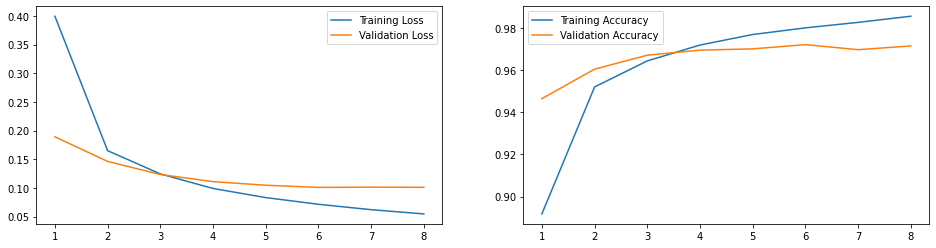

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#Experiment 6: 
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images (with 75% of training images variance lying along these components). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with PCA decomposition.

In [ ]:
pca = PCA(n_components=0.75)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [ ]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 34), (55000, 34), (5000, 34))

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(34,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 55)                1925      
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 2,485
Trainable params: 2,485
Non-trainable params: 0
_________________________________________________________________


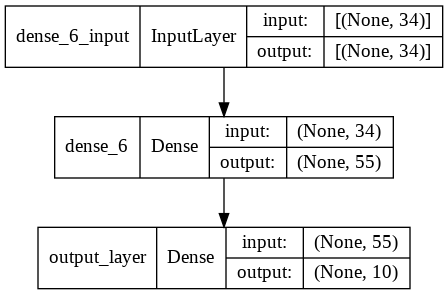

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_red, train_labels, 
                    epochs = 50, validation_data=(val_images_red, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
54944/55000 [============================>.] - ETA: 0s - loss: 0.4514 - accuracy: 0.8701

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 2s 44us/sample - loss: 0.4512 - accuracy: 0.8701 - val_loss: 0.2124 - val_accuracy: 0.9392
Epoch 2/50
55000/55000 [==============================] - 2s 40us/sample - loss: 0.1909 - accuracy: 0.9444 - val_loss: 0.1507 - val_accuracy: 0.9578
Epoch 3/50
55000/55000 [==============================] - 2s 40us/sample - loss: 0.1480 - accuracy: 0.9563 - val_loss: 0.1298 - val_accuracy: 0.9638
Epoch 4/50
55000/55000 [==============================] - 2s 40us/sample - loss: 0.1273 - accuracy: 0.9617 - val_loss: 0.1175 - val_accuracy: 0.9680
Epoch 5/50
55000/55000 [==============================] - 2s 42us/sample - loss: 0.1147 - accuracy: 0.9658 - val_loss: 0.1080 - val_accuracy: 0.9690
Epoch 6/50
55000/55000 [==============================] - 2s 41us/sample - loss: 0.1062 - accuracy: 0.9686 - val_loss: 0.1024 - val_accuracy: 0.9722
Epoch 7/50
55000/55000 [==============================] - 2s 40us/sample - loss: 0.0994 - accuracy: 0.9701 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9697999954223633, test loss: 0.10649296235758811


## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

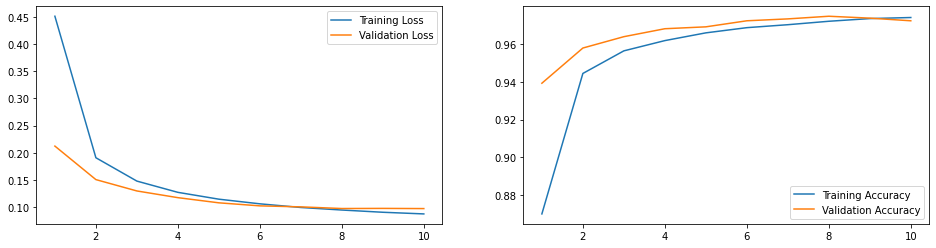

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#Experiment 7: 
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images (with 80% of training images variance lying along these components). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with PCA decomposition.

In [ ]:
pca = PCA(n_components=0.80)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [ ]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 44), (55000, 44), (5000, 44))

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 50 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(44,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                2250      
                                                                 
 output_layer (Dense)        (None, 10)                510       
                                                                 
Total params: 2,760
Trainable params: 2,760
Non-trainable params: 0
_________________________________________________________________


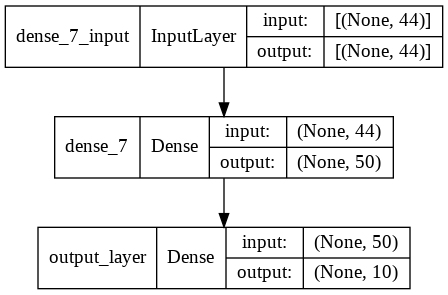

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_red, train_labels, 
                    epochs = 50, validation_data=(val_images_red, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4501 - accuracy: 0.8701 - val_loss: 0.2164 - val_accuracy: 0.9394


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/50
55000/55000 [==============================] - 2s 41us/sample - loss: 0.1980 - accuracy: 0.9406 - val_loss: 0.1580 - val_accuracy: 0.9548
Epoch 3/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.1514 - accuracy: 0.9546 - val_loss: 0.1322 - val_accuracy: 0.9626
Epoch 4/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.1264 - accuracy: 0.9630 - val_loss: 0.1177 - val_accuracy: 0.9680
Epoch 5/50
55000/55000 [==============================] - 2s 45us/sample - loss: 0.1126 - accuracy: 0.9669 - val_loss: 0.1111 - val_accuracy: 0.9684
Epoch 6/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.1023 - accuracy: 0.9696 - val_loss: 0.1054 - val_accuracy: 0.9704
Epoch 7/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0954 - accuracy: 0.9716 - val_loss: 0.0996 - val_accuracy: 0.9732
Epoch 8/50
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0898 - accuracy: 0.9732

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9685999751091003, test loss: 0.10704947391748429


## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

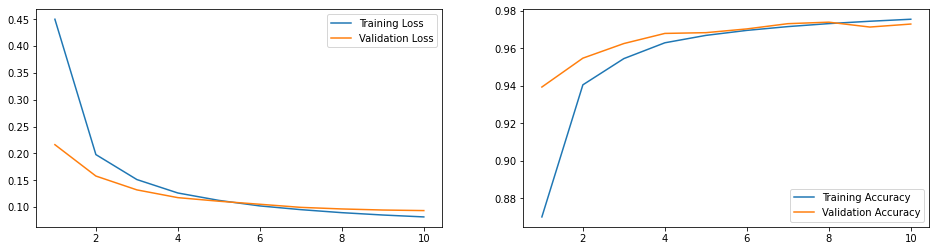

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#Experiment 8: 
Use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with Random Forests

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(random_state=42)

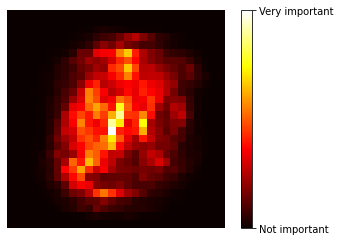

In [ ]:
plot_reduced_dim_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# plt.savefig("mnist_feature_importance_plot")
plt.show()

In [ ]:
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [ ]:
#create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 70), (5000, 784), (10000, 70))

## Visualizing the 70 pixels

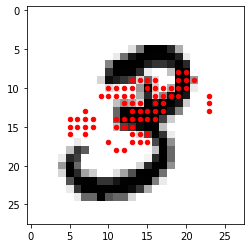

In [ ]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## Build, train, and test the network (without reducing dimensions)
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 55)                43175     
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 43,735
Trainable params: 43,735
Non-trainable params: 0
_________________________________________________________________


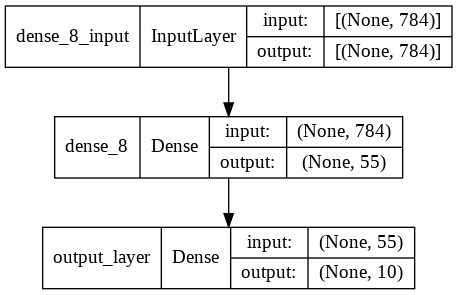

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images, train_labels, 
                    epochs = 50, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
54368/55000 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.9085

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 4s 68us/sample - loss: 0.3240 - accuracy: 0.9090 - val_loss: 0.1834 - val_accuracy: 0.9500
Epoch 2/50
55000/55000 [==============================] - 4s 64us/sample - loss: 0.1698 - accuracy: 0.9510 - val_loss: 0.1426 - val_accuracy: 0.9612
Epoch 3/50
55000/55000 [==============================] - 3s 63us/sample - loss: 0.1307 - accuracy: 0.9620 - val_loss: 0.1243 - val_accuracy: 0.9628
Epoch 4/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.1107 - accuracy: 0.9688 - val_loss: 0.1217 - val_accuracy: 0.9650
Epoch 5/50
55000/55000 [==============================] - 3s 60us/sample - loss: 0.0960 - accuracy: 0.9730 - val_loss: 0.1063 - val_accuracy: 0.9712
Epoch 6/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.0856 - accuracy: 0.9755 - val_loss: 0.1063 - val_accuracy: 0.9710
Epoch 7/50
55000/55000 [==============================] - 3s 61us/sample - loss: 0.0783 - accuracy: 0.9780 - val_loss

### Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9718000292778015, test loss: 0.11019385225028382


## Build, train, and test the network with reduced dimensions
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(70,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 55)                3905      
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 4,465
Trainable params: 4,465
Non-trainable params: 0
_________________________________________________________________


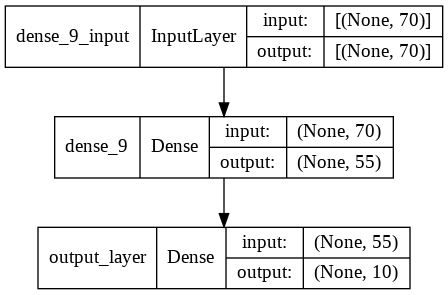

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_sm, train_labels, 
                    epochs = 50, validation_data=(val_images_sm, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
54816/55000 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.7966

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 3s 48us/sample - loss: 0.6814 - accuracy: 0.7968 - val_loss: 0.4684 - val_accuracy: 0.8638
Epoch 2/50
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4496 - accuracy: 0.8645 - val_loss: 0.3807 - val_accuracy: 0.8936
Epoch 3/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.3801 - accuracy: 0.8858 - val_loss: 0.3377 - val_accuracy: 0.9040
Epoch 4/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.3387 - accuracy: 0.8971 - val_loss: 0.3156 - val_accuracy: 0.9082
Epoch 5/50
55000/55000 [==============================] - 2s 43us/sample - loss: 0.3116 - accuracy: 0.9045 - val_loss: 0.2967 - val_accuracy: 0.9174
Epoch 6/50
55000/55000 [==============================] - 2s 44us/sample - loss: 0.2934 - accuracy: 0.9108 - val_loss: 0.2895 - val_accuracy: 0.9154
Epoch 7/50
55000/55000 [==============================] - 2s 44us/sample - loss: 0.2797 - accuracy: 0.9154 - val_loss

### Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_sm, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9258000254631042, test loss: 0.24964091657102108


### Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

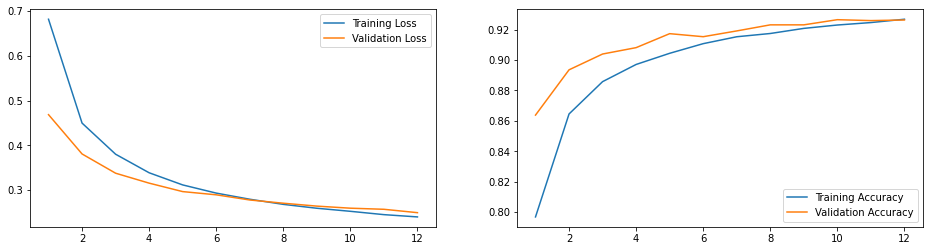

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#Experiment 9: 
Use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 100 features (pixels). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with Random Forests

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(random_state=42)

In [ ]:
n = 100
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

100

In [ ]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 100), (5000, 784), (10000, 100))

## Visualizing the 100 pixels

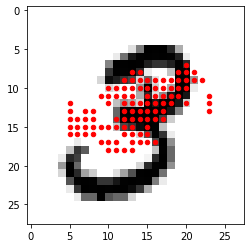

In [ ]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(100,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 55)                5555      
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 6,115
Trainable params: 6,115
Non-trainable params: 0
_________________________________________________________________


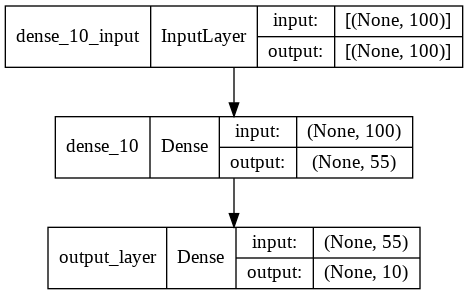

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_sm, train_labels, 
                    epochs = 50, validation_data=(val_images_sm, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
54848/55000 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.8306

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 3s 54us/sample - loss: 0.5847 - accuracy: 0.8307 - val_loss: 0.3871 - val_accuracy: 0.8900
Epoch 2/50
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3627 - accuracy: 0.8916 - val_loss: 0.3191 - val_accuracy: 0.9128
Epoch 3/50
55000/55000 [==============================] - 3s 47us/sample - loss: 0.3012 - accuracy: 0.9101 - val_loss: 0.2780 - val_accuracy: 0.9198
Epoch 4/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2662 - accuracy: 0.9203 - val_loss: 0.2577 - val_accuracy: 0.9260
Epoch 5/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2434 - accuracy: 0.9278 - val_loss: 0.2480 - val_accuracy: 0.9294
Epoch 6/50
55000/55000 [==============================] - 2s 44us/sample - loss: 0.2280 - accuracy: 0.9323 - val_loss: 0.2396 - val_accuracy: 0.9334
Epoch 7/50
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2152 - accuracy: 0.9363 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_sm, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9397000074386597, test loss: 0.20239527534767984


## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

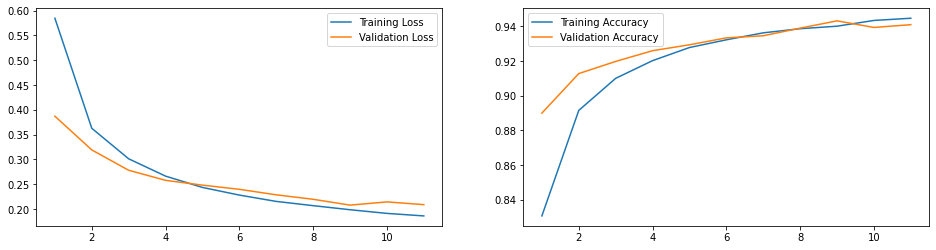

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#Experiment 10: 
Use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 200 features (pixels). 

### Load MNIST data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print('train_image:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_image:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


### Preprocess the data

In [ ]:
# Reshape and normalize the images:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32') / 255

test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32') / 255

In [ ]:
#validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Reducing dimensionality of the data with Random Forests

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(random_state=42)

In [ ]:
n = 200
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

200

In [ ]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 200), (5000, 784), (10000, 200))

## Visualizing the 200 pixels

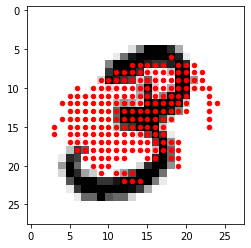

In [ ]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## Build the network
The network will have 2 Dense layers. The first hidden layer will consist of 55 nodes with the activation function ReLu. 

The last layer will have 10 nodes that, with softmax, will return 10 probability scores to correspond to each 10 digit class.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(55, activation='relu', input_shape=(200,)))
model.add(layers.Dense(10, activation='softmax', name = "output_layer"))   

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 55)                11055     
                                                                 
 output_layer (Dense)        (None, 10)                560       
                                                                 
Total params: 11,615
Trainable params: 11,615
Non-trainable params: 0
_________________________________________________________________


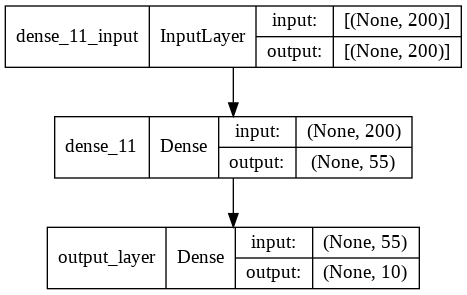

In [ ]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the model
The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

## Train the model
The model if fit to its training data. The model is trained for 50 epochs with batch size 32 (the default). An early stopping callback is added to stop training with the validation accuracy no longer improves after 2 epochs. 

In [ ]:
history = model.fit(train_images_sm, train_labels, 
                    epochs = 50, validation_data=(val_images_sm, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
54592/55000 [============================>.] - ETA: 0s - loss: 0.4155 - accuracy: 0.8810

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 3s 59us/sample - loss: 0.4144 - accuracy: 0.8813 - val_loss: 0.2545 - val_accuracy: 0.9284
Epoch 2/50
55000/55000 [==============================] - 3s 51us/sample - loss: 0.2266 - accuracy: 0.9341 - val_loss: 0.1982 - val_accuracy: 0.9442
Epoch 3/50
55000/55000 [==============================] - 3s 52us/sample - loss: 0.1753 - accuracy: 0.9488 - val_loss: 0.1515 - val_accuracy: 0.9594
Epoch 4/50
55000/55000 [==============================] - 3s 52us/sample - loss: 0.1476 - accuracy: 0.9570 - val_loss: 0.1341 - val_accuracy: 0.9616
Epoch 5/50
55000/55000 [==============================] - 3s 53us/sample - loss: 0.1317 - accuracy: 0.9618 - val_loss: 0.1338 - val_accuracy: 0.9614
Epoch 6/50
55000/55000 [==============================] - 3s 52us/sample - loss: 0.1198 - accuracy: 0.9648 - val_loss: 0.1223 - val_accuracy: 0.9656
Epoch 7/50
55000/55000 [==============================] - 3s 53us/sample - loss: 0.1116 - accuracy: 0.9676 - val_loss

## Test the model
Evaluate the model on the test set.

In [ ]:
test_loss, test_acc = model.evaluate(test_images_sm, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9639999866485596, test loss: 0.1249484469362069


## Plot performance metrics
`Matplotlib` is used to create two plots on training and validation loss for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

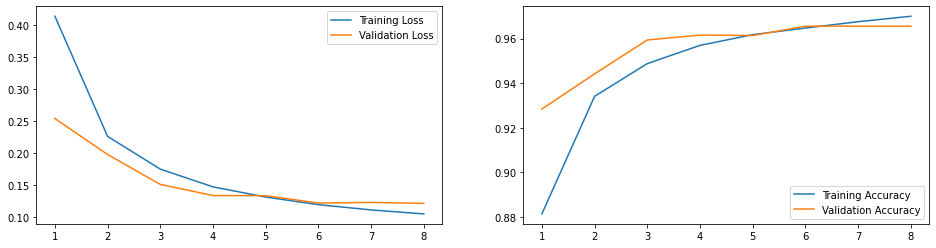

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()